In [1]:
# PyTorch
import torch
from torch.utils.data import random_split
# PyG
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
# PyTorch-Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
# NetworkX
import networkx as nx
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
# Local
from schnet import SchNet
from schnetspec import SchNetspec
from dataset import SchNetDataset
from utils.model import train_schnet, val_schnet

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'PyG version: {torch_geometric.__version__}')
print(f'Lightning version: {pl.__version__}')

Pytorch version: 2.4.1+cu124
PyG version: 2.5.3
Lightning version: 2.4.0


In [3]:
# --- Path raw directory containing the data
path = "../"
dataset = SchNetDataset(path)

/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) an

In [4]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
#torch.save(dataset, './processed/test_cor_pyg.pt')

SchNetDataset(317)
------------
Number of graphs: 317
Number of features: 0
Number of classes: 0

Data(pos=[43, 3], z=[43], spectrum=[200], idx=[1], smiles='c12[c:4]3[c:6]4[c:7]([H:29])[c:9]([H:30])[c:10]5[c:8]3[c:12]3[c:16]6[c:20]1[C:22]1([C:21]([H:36])=[C:19]([H:37])[C:18]6=[C:17]([H:40])[C:15]([H:38])([H:39])[C:14]36[C:13]([H:32])([C:11]5([H:31])[H:35])[O:26]6)[C:23]([H:33])([C:1]([H:27])([H:34])[C:2]23[C:3]([H:28])([C:5]4([H:41])[H:42])[O:24]3)[O:25]1')


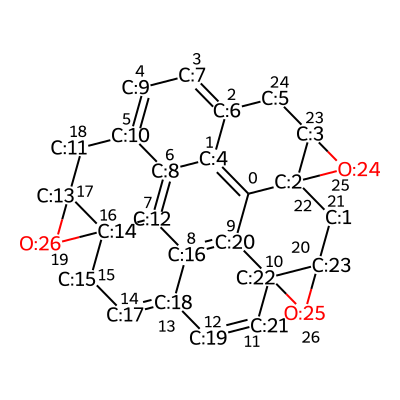

In [5]:
# --- View molecule using RDKit
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

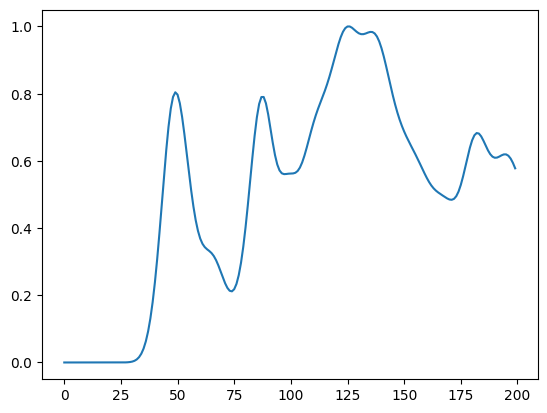

In [6]:
# --- Show molecule spectrum
plt.plot(data.spectrum)
plt.show()

In [7]:
# Random seed to reproduce data split
generator = torch.Generator().manual_seed(11)
# Split dataset into train, validation and test sets
train_data, val_data, test_data = random_split(dataset, [0.75, 0.125, 0.125], generator)

print(f'Length of training data: {len(train_data)}')
print(f'Length of validation data: {len(val_data)}')
print(f'Length of testing data: {len(test_data)}')

torch.save(test_data, './processed/test_schnet.pt')

Length of training data: 238
Length of validation data: 40
Length of testing data: 39


In [8]:
# Load data splits into DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=40, shuffle=False)

print(f'Number of batches in train loader: {len(train_loader)}')
print(f'Number of batches in val loader: {len(val_loader)}')

Number of batches in train loader: 8
Number of batches in val loader: 1


In [9]:
# --- Select device to run model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# --- Set seed for model to allow for reproducibility
seed = 199
torch.manual_seed(seed)

In [10]:
model = SchNet(hidden_channels=300, num_filters=200, num_interactions=6,
               num_gaussians=50, cutoff=10.0).to(device)
print(model)
print('----')
print(f'Training will be performed on: {device}')

SchNet(hidden_channels=300, num_filters=200, num_interactions=6, num_gaussians=50, cutoff=10.0)
----
Training will be performed on: cuda


In [11]:
# --- Set model optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
# --- Set optimizer scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

In [12]:
num_epochs = 3

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    loss = train_schnet(model, train_loader, optimizer, device) / len(train_loader)

    val_error = val_schnet(model, val_loader, device) / len(val_loader)

    scheduler.step(val_error)

    train_losses.append(loss)
    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]['lr']

    if epoch % 2 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:.3f}, TrainLoss: {loss:.5f}, ValLoss: {val_error:.5f}')



tensor(361.6176, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(54322.3633, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2586532.5000, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(63026088., device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(941331.1250, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(831255.8750, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(9.6619e+09, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(4.3163e+08, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 000, LR: 0.010, TrainLoss: 1270124326.43512, ValLoss: 111410765824.00000
tensor(1.1302e+11, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.1551e+10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1254e+11, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6640e+11, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7955e+13, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1755e+11, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.4797e+09, devi

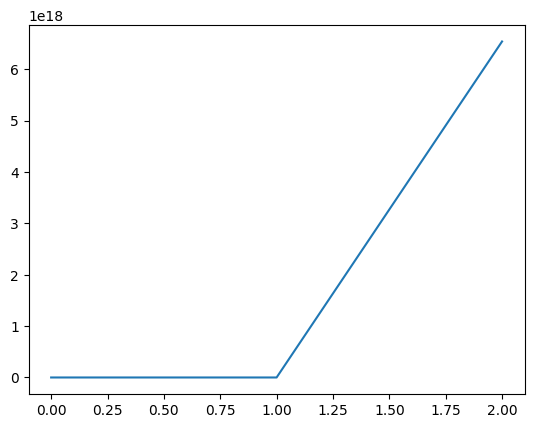

In [13]:
plt.plot(train_losses)
plt.show()